In [1]:
import torch
import torch.distributions as dist
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import json


In [2]:
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA runtime:", torch.version.cuda)
    print("cuDNN:", torch.backends.cudnn.version())
    print("GPU:", torch.cuda.get_device_name(0))
    print("Capability:", torch.cuda.get_device_capability(0))


Torch: 2.9.0
CUDA available: False


In [3]:
# CONFIG SAUVEGARDE 
SAVE = True  

def get_next_run_id(exp_dir: str) -> str:
    existing = [
        d for d in os.listdir(exp_dir)
        if d.isdigit() and len(d) == 3
    ]
    print(existing)
    
    if not existing:
        return "001"
    return f"{int(max(existing)) +1:03d}"

BASE_PATH = os.getcwd()
RUNS_ROOT = os.path.join(BASE_PATH, "runs_ncsn")
os.makedirs(RUNS_ROOT, exist_ok=True)

EXP_NAME = "MNIST_Test"
EXP_DIR = os.path.join(RUNS_ROOT, EXP_NAME)
os.makedirs(EXP_DIR, exist_ok=True)

RUN_ID = get_next_run_id(EXP_DIR)
RUN_DIR = os.path.join(EXP_DIR, RUN_ID)  # <- fix ici

if SAVE:
    os.makedirs(RUN_DIR, exist_ok=True)
    FIG_DIR = os.path.join(RUN_DIR, "figures")
    WEIGHTS_DIR = os.path.join(RUN_DIR, "weights")
    LOGS_DIR = os.path.join(RUN_DIR, "logs")
    os.makedirs(FIG_DIR, exist_ok=True)
    os.makedirs(WEIGHTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)
else:
    FIG_DIR = WEIGHTS_DIR = LOGS_DIR = None


['001']


In [4]:
torch.set_default_dtype(torch.float32)

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor

elif torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor
    
def t(x):
    # j'avais des problèmes de type avec les long 
    return torch.as_tensor(x, dtype=torch.get_default_dtype()).to(device)

print(device)


mps


## Dataset 

In [5]:

transform = transforms.Compose([
    transforms.ToTensor(),                          # [0,1]
    transforms.Lambda(lambda x: x * 2.0 - 1.0)      # [-1,1]
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])
tensor(-1.) tensor(1.)


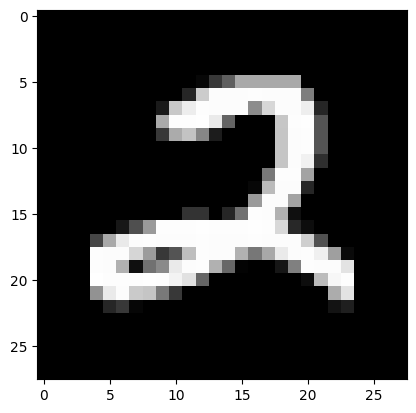

Label: 2


In [6]:

dataloader = DataLoader(training_data,batch_size=128,shuffle=True)
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
print(img.min(),img.max())
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:

class SigmaEmbedding(nn.Module):
    """
    Embed scalar sigma (B,), (B,1) or (B,1,1,1) -> (B, emb_dim)
    via log-sigma + MLP.
    """
    def __init__(self, emb_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
        )

    def forward(self, sigma: torch.Tensor) -> torch.Tensor:
        # Accept (B,), (B,1), (B,1,1,1)
        if sigma.dim() == 4:          # (B,1,1,1)
            sigma = sigma.view(sigma.size(0), 1)
        elif sigma.dim() == 1:        # (B,)
            sigma = sigma.unsqueeze(1)
        elif sigma.dim() == 2:        # (B,1)
            pass
        else:
            raise ValueError(f"Unexpected sigma shape: {sigma.shape}")

        if sigma.size(1) != 1:
            raise ValueError(f"Sigma should have shape (B,1), got {sigma.shape}")

        log_sigma = torch.log(sigma)
        return self.net(log_sigma)    # (B, emb_dim)


class ResBlock(nn.Module):
    """
    Conv-ResNet block modulated by sigma embedding via per-channel bias.
    """
    def __init__(self, in_ch: int, out_ch: int, emb_dim: int, groups: int = 8):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.norm1 = nn.GroupNorm(num_groups=min(groups, in_ch), num_channels=in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        self.norm2 = nn.GroupNorm(num_groups=min(groups, out_ch), num_channels=out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # Projections de l'embedding -> biais par canal (out_ch)
        self.emb_proj1 = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, out_ch))
        self.emb_proj2 = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, out_ch))

        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        """
        x:   (B, in_ch, H, W)
        emb: (B, emb_dim)
        """
        h = self.conv1(self.act1(self.norm1(x)))
        # injection biais après conv1
        h = h + self.emb_proj1(emb).unsqueeze(-1).unsqueeze(-1)

        h = self.conv2(self.act2(self.norm2(h)))
        # injection biais après conv2
        h = h + self.emb_proj2(emb).unsqueeze(-1).unsqueeze(-1)

        return h + self.skip(x)



class SmallUNetSigma(nn.Module):
    """
    Small U-Net for images, conditioned on scalar sigma.

    - in_ch:       1 (MNIST), 3 (CIFAR), etc.
    - base_ch:     base number of channels (e.g. 64)
    - channel_mults: per-level multipliers, e.g. (1,2,4)
    - emb_dim:     sigma embedding dim
    """
    def __init__(
        self,
        in_ch: int = 1,
        base_ch: int = 64,
        channel_mults=(1, 2, 4),
        emb_dim: int = 128,
    ):
        super().__init__()

        self.in_ch = in_ch
        self.base_ch = base_ch
        self.channel_mults = channel_mults

        self.sigma_emb = SigmaEmbedding(emb_dim)

        # Initial projection
        self.init_conv = nn.Conv2d(in_ch, base_ch, kernel_size=3, padding=1)

        # ----- ENCODER -----
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()

        curr_ch = base_ch
        num_levels = len(channel_mults)

        for level in range(num_levels):
            out_ch = base_ch * channel_mults[level]
            self.down_blocks.append(ResBlock(curr_ch, out_ch, emb_dim))
            curr_ch = out_ch

            # Downsample after this block, except for the deepest level
            if level < num_levels - 1:
                self.down_samples.append(
                    nn.Conv2d(curr_ch, curr_ch, kernel_size=3, stride=2, padding=1)
                )

        self.bottleneck_ch = curr_ch

        # ----- BOTTLENECK -----
        self.mid_block1 = ResBlock(curr_ch, curr_ch, emb_dim)
        self.mid_block2 = ResBlock(curr_ch, curr_ch, emb_dim)

        # ----- DECODER -----
        self.up_samples = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        # On remonte les niveaux (sauf le bottleneck) en sens inverse
        # Les skips seront pris sur les sorties des blocks encoder avant downsample
        for level in reversed(range(num_levels - 1)):
            skip_ch = base_ch * channel_mults[level]

            # upsample: garder curr_ch
            self.up_samples.append(
                nn.ConvTranspose2d(
                    curr_ch, curr_ch,
                    kernel_size=4, stride=2, padding=1
                )
            )
            # après concat: curr_ch (up) + skip_ch
            self.up_blocks.append(
                ResBlock(curr_ch + skip_ch, skip_ch, emb_dim)
            )

            curr_ch = skip_ch

        # Final projection to input channels
        self.final_ch = curr_ch
        self.out_conv = nn.Sequential(
            nn.GroupNorm(num_groups=min(8, self.final_ch), num_channels=self.final_ch),
            nn.SiLU(),
            nn.Conv2d(self.final_ch, in_ch, kernel_size=3, padding=1),
        )

    def forward(self, x: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        """
        x:     (B, C, H, W)
        sigma: (B,), (B,1), or (B,1,1,1)
        """
        B, C, H, W = x.shape
        emb = self.sigma_emb(sigma)  # (B, emb_dim)

        # ----- ENCODE -----
        h = self.init_conv(x)
        skips = []
        ds_idx = 0

        for level, block in enumerate(self.down_blocks):
            h = block(h, emb)

            # si on n'est pas au niveau le plus profond,
            # on stocke le skip AVANT le downsample
            if level < len(self.down_samples):
                skips.append(h)
                h = self.down_samples[ds_idx](h)
                ds_idx += 1

        # ----- BOTTLENECK -----
        h = self.mid_block1(h, emb)
        h = self.mid_block2(h, emb)

        # ----- DECODE -----
        # on consomme les skips du plus profond au plus proche de l'entrée
        for up, block in zip(self.up_samples, self.up_blocks):
            h = up(h)

            skip = skips.pop()  # shape compatible en canaux

            # align spatial dimensions si besoin (off-by-one)
            if h.shape[-2:] != skip.shape[-2:]:
                H = min(h.shape[-2], skip.shape[-2])
                W = min(h.shape[-1], skip.shape[-1])
                h = h[:, :, :H, :W]
                skip = skip[:, :, :H, :W]

            h = torch.cat([h, skip], dim=1)
            h = block(h, emb)

        out = self.out_conv(h)
        return out



In [8]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])


in_ch = 1  # or 3
test = SmallUNetSigma(
    in_ch=in_ch,
    base_ch=128,
    channel_mults=(1, 2, 4),  # small
    emb_dim=128,
).to(device)

count_n_param(test)

24125441

In [43]:



def LossNCSN(model, x, sigmas, eps_trainning: bool = False):
    """
    x:      (B, C, H, W) ou (B, D)
    sigmas: (n_sigmas,) tensor
    modèle:
        f(x_noisy, sigma) -> même shape que x
        sigma: (B,), (B,1) ou (B,1,1,1)
    """
    B = x.size(0)
    device = x.device

    # 1) sample un sigma par sample
    idx = torch.randint(0, len(sigmas), (B,), device=device)
    sigma_vals = sigmas[idx]  # (B,)

    # 2) sigma pour le bruit: broadcast à la shape de x
    sigma_noise = sigma_vals.view(B, 1)
    while sigma_noise.dim() < x.dim():
        sigma_noise = sigma_noise.unsqueeze(-1)  # -> (B,1,1,1) si image

    # 3) sigma pour le modèle: on lui passe sigma_noise tel quel
    sigma_model = sigma_noise

    # 4) bruitage
    eps = torch.randn_like(x)
    x_noisy = x + sigma_noise * eps

    # 5) epsilon-training
    if eps_trainning:
        eps_hat = model(x_noisy, sigma_model)
        loss = ((eps_hat + eps) ** 2).mean()
        return loss

    # 6) score-training
    s_hat = model(x_noisy, sigma_model)
    target = -eps / (sigma_noise + 1e-8)
    lambda_i = sigma_noise**2              # (B,1)
    loss_i = ((s_hat - target)**2).sum(dim=-1, keepdim=True)  # (B,1)
    loss = (lambda_i * loss_i).mean()
    return loss





In [44]:
def construct_noise_linspace(min,max,L):
    return torch.linspace(min,max,L).flip(0).to(device)

def construct_noise_logspace(sigma_min,sigma_max,L):
    return torch.logspace(
        torch.log10(t(sigma_min)),
        torch.log10(t(sigma_max)),L
    ).flip(0).to(device)
    

In [45]:
ALD_step_size = 0.2
ALD_T = 2000
ALD_n_chain = 2000

batch_size = 128
N_train = 4000
EVAL_EVERY = 1000
lr = 1e-3
HIDDEN_DIM = 258
SIGMA_EMB_DIM = 100

# Sigma config
SIGMA_MIN = 5e-2        
SIGMA_MAX = 1
N_SIGMAS = 10
SIGMA_SCHEDULE = "lin"    # ou "lin"
EPS_TRAINNING = False    


if SIGMA_SCHEDULE == "lin":
    sigmas = construct_noise_logspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
elif SIGMA_SCHEDULE == "lin":
    sigmas = construct_noise_linspace(SIGMA_MIN, SIGMA_MAX, N_SIGMAS)
else:
    raise ValueError(f"Unknown SIGMA_SCHEDULE: {SIGMA_SCHEDULE}")

in_ch = 1  # or 3
model = SmallUNetSigma(
    in_ch=in_ch,
    base_ch=128,
    channel_mults=(1, 2, 4),  # small
    emb_dim=128,
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# SAUVEGARDE des HYPERPARAMS 
if SAVE:
    hparams = {
    "batch_size": batch_size,
    "N_train": N_train,
    "EVAL_EVERY": EVAL_EVERY,
    "lr": lr,
    "EPS_TRAINNING": EPS_TRAINNING,
    "sigma": {
        "schedule": SIGMA_SCHEDULE,
        "min": SIGMA_MIN,
        "max": SIGMA_MAX,
        "n_sigmas": N_SIGMAS,
        "values": [float(s) for s in sigmas],
    },
    "ALD": {
        "step_size": float(ALD_step_size),
        "T": ALD_T,
        "n_chain": ALD_n_chain,
    },
    "device": str(device),
    "model": {
        "hidden_dim": HIDDEN_DIM,
        "sigma_emb_dim": SIGMA_EMB_DIM,
    },
    }


    with open(os.path.join(LOGS_DIR, "hparams.json"), "w") as f:
        json.dump(hparams, f, indent=4)


In [46]:
model.train()
L = []
eval_steps = []

for step in range(N_train):
    x,_ = next(iter(dataloader))
    x = x.to(device)
    optimizer.zero_grad()

    loss = LossNCSN(model, x, sigmas, EPS_TRAINNING)
    loss.backward()
    optimizer.step()
    L.append(loss.item())
    
    if (step + 1) % EVAL_EVERY == 0 or step==N_train-1:
        model.eval()
        eval_steps.append(step+1)
        print(f"[{step+1}/{N_train}] train loss (last {EVAL_EVERY}) = {np.mean(L[-EVAL_EVERY:]):.4f}")
        # saving des poids en cours de route
        if SAVE : 
            torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))
        model.train()

# SAUVEGARDE METRICS BRUTES 
if SAVE:
    np.save(os.path.join(LOGS_DIR, "train_loss.npy"), np.array(L))
    np.save(os.path.join(LOGS_DIR, "steps_eval.npy"), np.array(eval_steps))
    # Poids du modèle
    torch.save(model.state_dict(), os.path.join(WEIGHTS_DIR, "model.pt"))


[1000/4000] train loss (last 1000) = 5.1609
[2000/4000] train loss (last 1000) = 2.5742
[3000/4000] train loss (last 1000) = 2.2724
[4000/4000] train loss (last 1000) = 2.1782


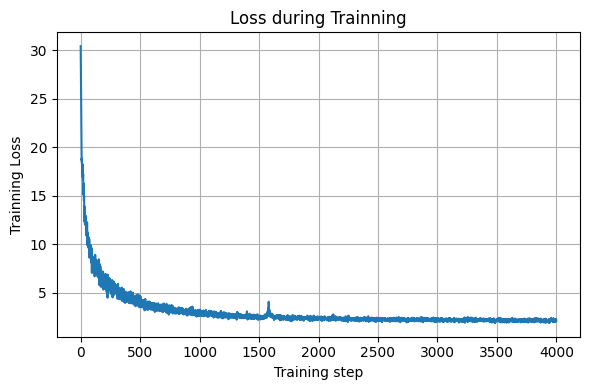

In [47]:
plt.figure(figsize=(6,4))
plt.title('Loss during Trainning')
plt.plot(L)
plt.xlabel("Training step")
plt.ylabel("Trainning Loss")
plt.grid(True)
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(FIG_DIR, "train_loss.png"), dpi=200)
plt.show()


In [48]:
# pas de gradient ici pour ALD 
def make_score_from_model(model, sigma_scalar,eps_loss = False):
    sigma_scalar = float(sigma_scalar)
    @torch.no_grad()
    def score(x):
        # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma)
    @torch.no_grad()
    def score_eps(x):
       # x: (B, x_dim)
        B = x.shape[0]
        sigma = x.new_full((B, 1), sigma_scalar)   # (B,1) 
        return model(x, sigma) /sigma
    if eps_loss : 
        return score_eps
    else : 
        return score


In [49]:
model.eval()
estimated_distribution_scores = [make_score_from_model(model,noise,EPS_TRAINNING) for noise in list(sigmas)]

In [59]:
NUM_BATCH = 10
N = []

data_iter = iter(dataloader)

for idx in range(N_SIGMAS):
    norm = 0.0
    s = sigmas[idx]              # scalaire, device déjà correct

    for _ in range(NUM_BATCH):
        
        x, _ = next(data_iter)
        x, _ = next(data_iter)

        x = x.to(device)
        B = x.size(0)

        # sigma de shape (B, 1, 1, 1) avec valeur s
        sigma = s.expand(B, 1)
        while sigma.dim() < x.dim():
            sigma = sigma.unsqueeze(-1)   # -> (B,1,1,1)

        # bruitage
        eps = torch.randn_like(x)
        x_noisy = x + sigma * eps

        # IMPORTANT : passer sigma (batch), pas le scalaire s
        score = model(x_noisy, sigma)

        
        # (on écrase toutes les dims sauf batch)
        score_sq = (score ** 2).view(B, -1).sum(dim=1).mean()

        norm += score_sq.item()

    N.append(s **2 * norm / NUM_BATCH)

N = torch.tensor(N, device=device) 
print(N)


tensor([781.3586, 786.8298, 774.1301, 761.9211, 741.3609, 726.7937, 707.6835,
        691.8420, 684.6132, 661.3840], device='cuda:0')


In [93]:
def annealded_langevin_sampler(prior,noisy_distrib_scores,noise_factor,step_size,T,n_chain):
    C=1
    H=28
    W=28
    X = prior.sample((n_chain, C, H, W)).to(device)
    for i in range(len(noisy_distrib_scores)):
        tau = step_size * noise_factor[i]
        print(tau)
        for step in range(T):
            X = X + tau*noisy_distrib_scores[i](X) + torch.sqrt(t(2*tau))*torch.randn_like(X)
            # print(torch.min(X),torch.max(X))
            if step ==0 or (step +1) % (T) == 0 : 
                for u in range(min(X.shape[0],3)):
                    plt.subplot(1,min(X.shape[0],3),u+1)
                    plt.imshow(X[u].clone().squeeze().cpu(),cmap='gray')
                plt.title(f'sigma : {noise_factor[i]}')
                plt.tight_layout()
                if SAVE:
                    plt.savefig(os.path.join(FIG_DIR, f"ALD_T{int(step):04d}_N{noise_factor[i]:.3f}_.png"), dpi=200)
                plt.show()
                
    return X 


In [96]:

sigma_prior = sigmas.max().item()  # ou sigmas.max().item()
prior_normal = dist.Normal(
    loc=torch.tensor(0.0, device=device),
    scale=torch.tensor(sigma_prior, device=device),
)
prior_unif = dist.Uniform(-1,1)

In [1]:
# ald estimated score
ALD_estimated_score = annealded_langevin_sampler(
    prior_normal,
    estimated_distribution_scores,
    sigmas,
    t(1/5  * 1e-3),
    1500,
    3
)



NameError: name 'annealded_langevin_sampler' is not defined

In [ ]:
## voir un éleéments de chaque distribution : 
for idx in range(N_SIGMAS):
    x_ref,_ = next(iter(dataloader))

    s = sigmas[idx]    
    x_ref = x_ref[0].to(device)
    x_noisy = x_ref + torch.randn_like(x_ref) * s
    plt.subplot(1,2,1)
    plt.imshow(x_ref.squeeze().cpu(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(x_noisy.squeeze().cpu(),cmap= 'gray',label = 'noisy | noise = {s}')
    plt.tight_layout()
    plt.show()